In [36]:
import ccxt
import pandas as pd
import numpy as np
import ta
import talib

# -------------------------------
# Fetch OHLCV data
# -------------------------------
exchange = ccxt.binance()
symbol = 'SIGN/USDT'
timeframe = '4h'
limit = 1000

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
df_base = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df_base['timestamp'] = pd.to_datetime(df_base['timestamp'], unit='ms')
df_base.set_index('timestamp', inplace=True)

# -------------------------------
# Feature engineering
# -------------------------------
def add_features(df):
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]

    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['histogram'] = df['macd'] - df['signal']

    try:
        df['dema9'] = talib.DEMA(df['close'].values, timeperiod=9)
    except Exception:
        df['dema9'] = df['close'].ewm(span=9).mean()

    df['sma3'] = ta.trend.sma_indicator(df['close'], window=3)

    # TSI
    delta = df['close'].diff()
    ema1 = delta.ewm(span=25, adjust=False).mean()
    ema2 = ema1.ewm(span=13, adjust=False).mean()
    abs_delta = delta.abs()
    abs_ema1 = abs_delta.ewm(span=25, adjust=False).mean()
    abs_ema2 = abs_ema1.ewm(span=13, adjust=False).mean()
    df['tsi'] = 100 * (ema2 / (abs_ema2.replace(0, np.nan)))
    df['tsi'] = df['tsi'].fillna(0)

    # Stochastic
    period = 14
    smooth_k = 3
    smooth_d = 3
    lowest_low = df['low'].rolling(period).min()
    highest_high = df['high'].rolling(period).max()
    df['%k'] = 100 * (df['close'] - lowest_low) / (highest_high - lowest_low + 1e-8)
    df['%k'] = df['%k'].rolling(smooth_k).mean()
    df['%d'] = df['%k'].rolling(smooth_d).mean()

    # ATR, OBV, ADX, CCI
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=14).adx()
    df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'], window=20)

    # Price features
    df['return_1'] = df['close'].pct_change()
    df['roll_mean_5'] = df['close'].rolling(5).mean()
    df['roll_std_5'] = df['close'].rolling(5).std()

    df = df.dropna().reset_index(drop=True)
    return df

df_features = add_features(df_base)


In [37]:
def label_reversals(df, window=5, atr_period=14, atr_mult=1.5):
    df = df.copy().reset_index(drop=True)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(atr_period).mean()
    
    df['swing_high'] = df['high'][(df['high'] == df['high'].rolling(window*2+1, center=True).max())]
    df['swing_low']  = df['low'][(df['low'] == df['low'].rolling(window*2+1, center=True).min())]

    df['Label'] = 1  # default: no reversal
    for i in range(window, len(df) - window):
        atr = df.loc[i, 'ATR']
        if np.isnan(atr):
            continue
        if not np.isnan(df.loc[i, 'swing_high']):
            future_min = df['low'].iloc[i:i+window].min()
            if df.loc[i, 'high'] - future_min > atr_mult * atr:
                df.loc[i, 'Label'] = 0  # Top reversal
        if not np.isnan(df.loc[i, 'swing_low']):
            future_max = df['high'].iloc[i:i+window].max()
            if future_max - df.loc[i, 'low'] > atr_mult * atr:
                df.loc[i, 'Label'] = 2  # Bottom reversal
    df.drop(['swing_high','swing_low'], axis=1, inplace=True)
    return df

df_reversal = label_reversals(df_features)


In [38]:
from sklearn.linear_model import LinearRegression

def label_trend_by_slope(df, window=5, normalize_by_vol=True):
    df = df.copy()
    log_price = np.log(df['close'])
    slopes = np.full(len(df), np.nan)

    for i in range(window, len(df)):
        y = log_price[i-window:i].values.reshape(-1,1)
        x = np.arange(window).reshape(-1,1)
        slopes[i] = LinearRegression().fit(x, y).coef_[0][0]

    if normalize_by_vol:
        vol = df['return_1'].rolling(window).std().values
        slopes = slopes / (vol + 1e-8)

    df['slope'] = slopes
    df['trend_label'] = np.where(df['slope'] > 0, 1, 0)
    df = df.dropna().reset_index(drop=True)
    return df

df_trend = label_trend_by_slope(df_features)


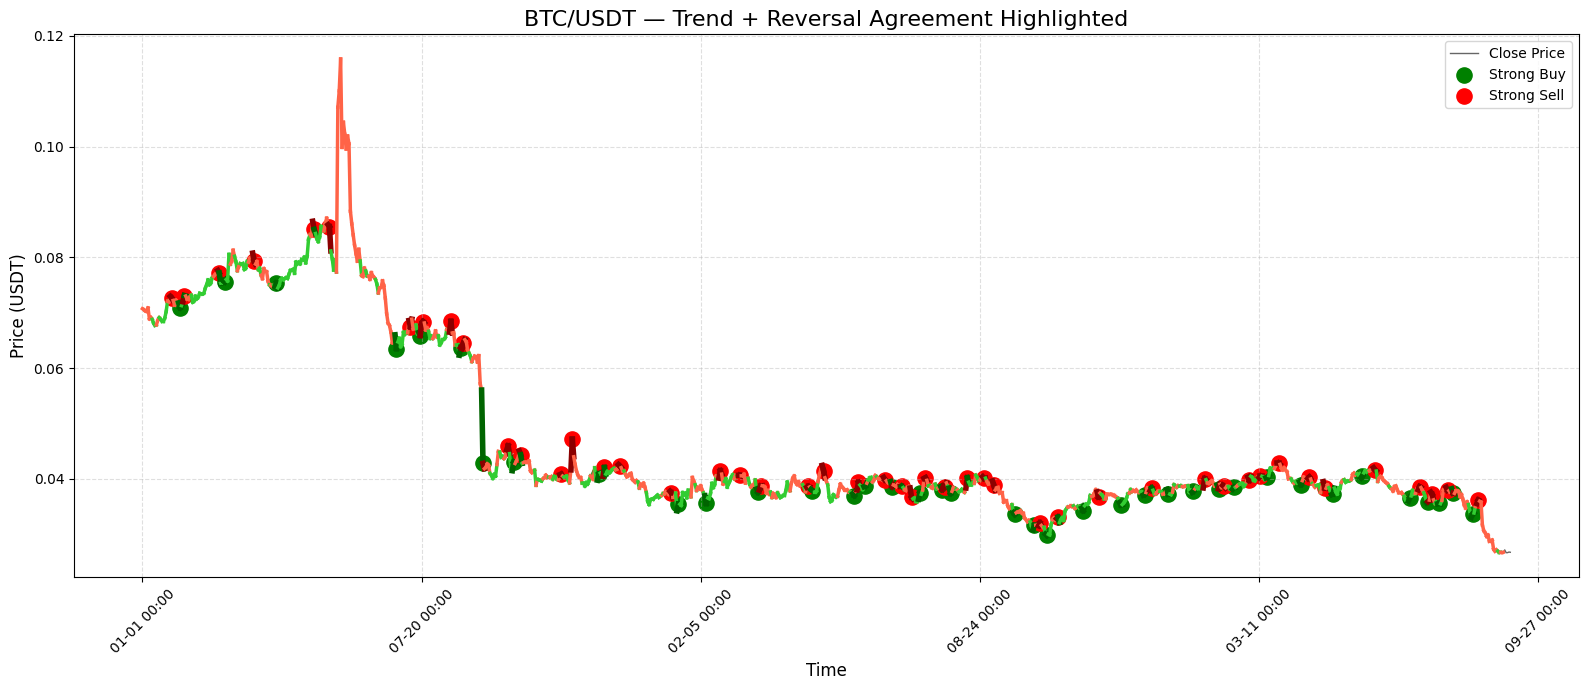

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_combined_agree_highlight(df_trend, df_reversal, df_price, symbol='BTC/USDT'):
    plt.figure(figsize=(16,7))
    x = df_price.index
    y = df_price['close']

    # Price line
    plt.plot(x, y, color='black', linewidth=1, alpha=0.6, label='Close Price')

    # -------------------------------
    # Identify agreement points
    # -------------------------------
    combined_up = df_reversal[(df_reversal['Label']==2) & (df_trend['trend_label']==1)].index
    combined_down = df_reversal[(df_reversal['Label']==0) & (df_trend['trend_label']==0)].index
    agreement_idx = sorted(list(combined_up) + list(combined_down))  # All agreement points

    # -------------------------------
    # Plot trend line with highlight
    # -------------------------------
    for i in range(1, len(df_trend)):
        # Default color
        color = 'limegreen' if df_trend['trend_label'].iloc[i]==1 else 'tomato'
        lw = 2.5  # default line width

        # If the segment includes an agreement point, make it thicker/brighter
        if i in agreement_idx or (i-1) in agreement_idx:
            color = 'darkgreen' if df_trend['trend_label'].iloc[i]==1 else 'darkred'
            lw = 4

        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=color, linewidth=lw)

    # -------------------------------
    # Plot agreeing points markers
    # -------------------------------
    plt.scatter(combined_up, df_price.loc[combined_up, 'close'], marker='o', color='green', s=120, label='Strong Buy')
    plt.scatter(combined_down, df_price.loc[combined_down, 'close'], marker='o', color='red', s=120, label='Strong Sell')

    plt.title(f"{symbol} — Trend + Reversal Agreement Highlighted", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price (USDT)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function
plot_combined_agree_highlight(df_trend, df_reversal, df_features)


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import joblib

class CryptoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, output_dim=2):
        super(CryptoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.int64)

def train_lstm(X, y, output_dim, model_name="model.pth", epochs=300, batch_size=32):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, f"scaler_{model_name}.pkl")

    window_size = 10
    X_seq, y_seq = create_sequences(X_scaled, y, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    # Class weights
    classes = np.unique(y_train.cpu())
    weights = compute_class_weight('balanced', classes=classes, y=y_train.cpu().numpy())
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    model = CryptoLSTM(input_dim=X.shape[1], output_dim=output_dim).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        total_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 50 == 0 or epoch==0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/(X_train.size(0)//batch_size):.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == y_test).float().mean().item()
    print(f"✅ Test Accuracy: {accuracy:.4f}")

    torch.save(model.state_dict(), model_name)
    print(f"✅ Model saved as {model_name}")
    return model, scaler


In [41]:
FEATURES = [
    'rsi','ema12','ema26','macd','signal','histogram','dema9','sma3','tsi','%k','%d',
    'atr','obv','adx','cci','return_1','roll_mean_5','roll_std_5'
]
X_rev = df_reversal[FEATURES].values
y_rev = df_reversal['Label'].values
model_reversal, scaler_reversal = train_lstm(X_rev, y_rev, output_dim=3, model_name="lstm_reversal.pth", epochs=300)


Epoch [1/300] Loss: 1.1460
Epoch [50/300] Loss: 0.7086
Epoch [100/300] Loss: 0.1896
Epoch [150/300] Loss: 0.2329
Epoch [200/300] Loss: 0.1707
Epoch [250/300] Loss: 0.1459
Epoch [300/300] Loss: 0.0076
✅ Test Accuracy: 0.8154
✅ Model saved as lstm_reversal.pth


In [42]:
X_trend = df_trend[FEATURES].values
y_trend = df_trend['trend_label'].values
model_trend, scaler_trend = train_lstm(X_trend, y_trend, output_dim=2, model_name="lstm_trend.pth", epochs=300)


Epoch [1/300] Loss: 0.7233


KeyboardInterrupt: 

In [ ]:
# Use the same feature set as in training
FEATURES = [
    'rsi', 'ema12', 'ema26', 'macd', 'signal', 'histogram',
    'dema9', 'sma3', 'tsi', '%k', '%d',
    'atr', 'obv', 'adx', 'cci',
    'return_1', 'roll_mean_5', 'roll_std_5'
]

# Make sure both df_trend and df_reversals have the same features
X_trend = df_trend[FEATURES].values
X_reversal = df_reversal[FEATURES].values


In [ ]:
# Load or reuse scalers from training
scaler_trend = joblib.load("scaler_lstm_trend.pth.pkl")       # trend model scaler
scaler_reversal = joblib.load("scaler_lstm_reversal.pth.pkl") # reversal model scaler

X_trend_scaled = scaler_trend.transform(X_trend)
X_reversal_scaled = scaler_reversal.transform(X_reversal)
def create_sequences(X, window_size=10):
    X_seq = []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
    return np.array(X_seq, dtype=np.float32)

window_size = 10
X_trend_seq = create_sequences(X_trend_scaled, window_size)
X_reversal_seq = create_sequences(X_reversal_scaled, window_size)


In [ ]:
X_trend_tensor = torch.tensor(X_trend_seq, dtype=torch.float32).to(device)
X_reversal_tensor = torch.tensor(X_reversal_seq, dtype=torch.float32).to(device)


In [ ]:
model_trend.eval()
model_reversal.eval()

with torch.no_grad():
    trend_preds = torch.argmax(model_trend(X_trend_tensor), dim=1).cpu().numpy()
    reversal_preds = torch.argmax(model_reversal(X_reversal_tensor), dim=1).cpu().numpy()


In [ ]:
# Pad with default value (e.g., 1 = no reversal for reversal, 0 = downtrend for trend)
df_trend['Predicted'] = np.concatenate([np.zeros(window_size), trend_preds])
df_reversal['Predicted'] = np.concatenate([np.ones(window_size), reversal_preds])


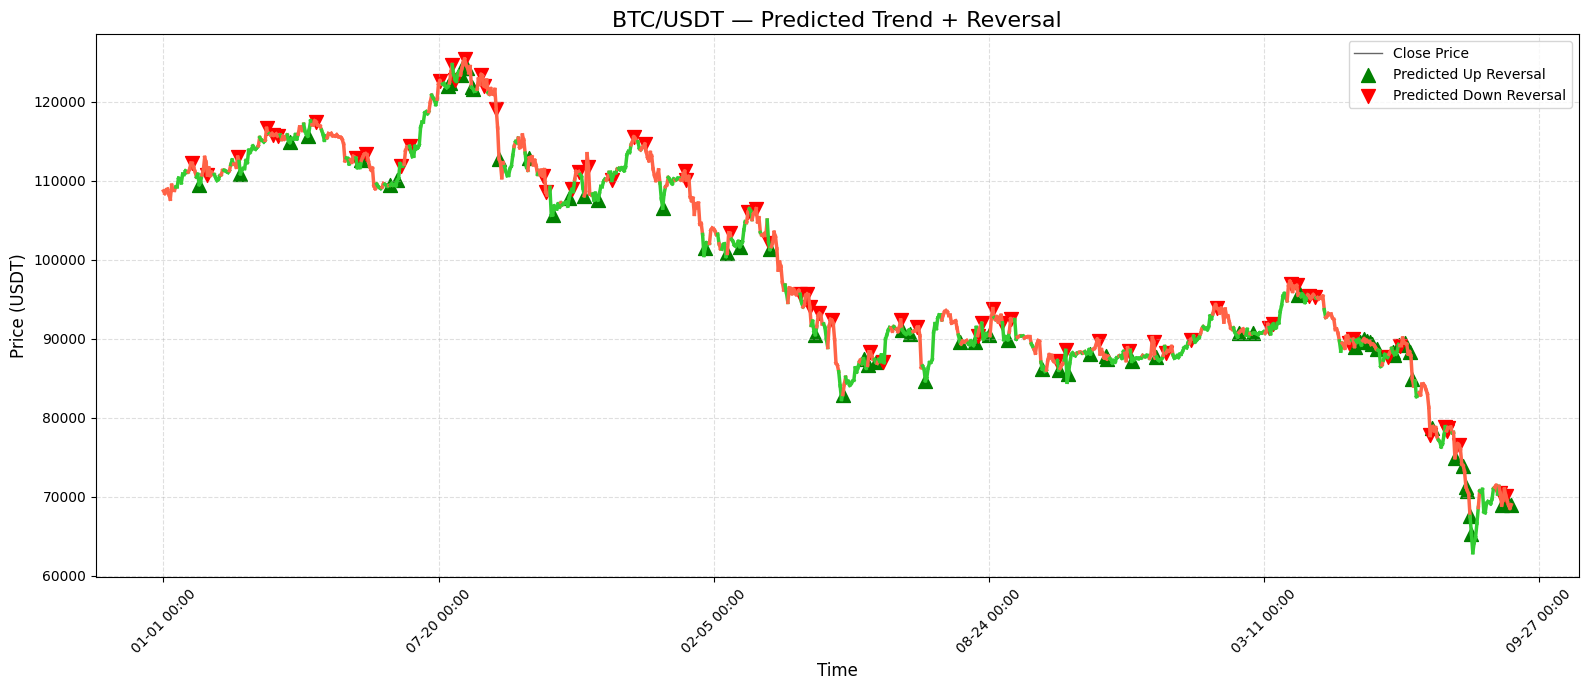

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_final_predictions(df_features, df_trend_pred, df_reversal_pred, symbol='BTC/USDT'):
    """
    Plot price with predicted trend lines and predicted reversal points on the same chart.
    
    Parameters
    ----------
    df_features : pd.DataFrame
        Original features with 'close' prices
    df_trend_pred : pd.DataFrame
        Contains 'Predicted' column with 0=Downtrend, 1=Uptrend
    df_reversal_pred : pd.DataFrame
        Contains 'Predicted' column with 0=Top reversal, 1=No reversal, 2=Bottom reversal
    """
    plt.figure(figsize=(16,7))
    x = df_features.index
    y = df_features['close']

    # --- Price line ---
    plt.plot(x, y, color='black', linewidth=1, alpha=0.6, label='Close Price')

    # --- Trend predictions ---
    df_trend_aligned = df_trend_pred.reindex(df_features.index)
    for i in range(1, len(df_trend_aligned)):
        color = 'limegreen' if df_trend_aligned['Predicted'].iloc[i]==1 else 'tomato'
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=color, linewidth=2.5)

    # --- Reversal predictions ---
    df_reversal_aligned = df_reversal_pred.reindex(df_features.index)
    uprev_idx = df_reversal_aligned.index[df_reversal_aligned['Predicted'] == 2]
    downrev_idx = df_reversal_aligned.index[df_reversal_aligned['Predicted'] == 0]

    plt.scatter(uprev_idx, df_features.loc[uprev_idx, 'close'], marker='^', color='green', s=100, label='Predicted Up Reversal')
    plt.scatter(downrev_idx, df_features.loc[downrev_idx, 'close'], marker='v', color='red', s=100, label='Predicted Down Reversal')

    # --- Formatting ---
    plt.title(f"{symbol} — Predicted Trend + Reversal", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price (USDT)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Usage
plot_final_predictions(df_features, df_trend, df_reversal)


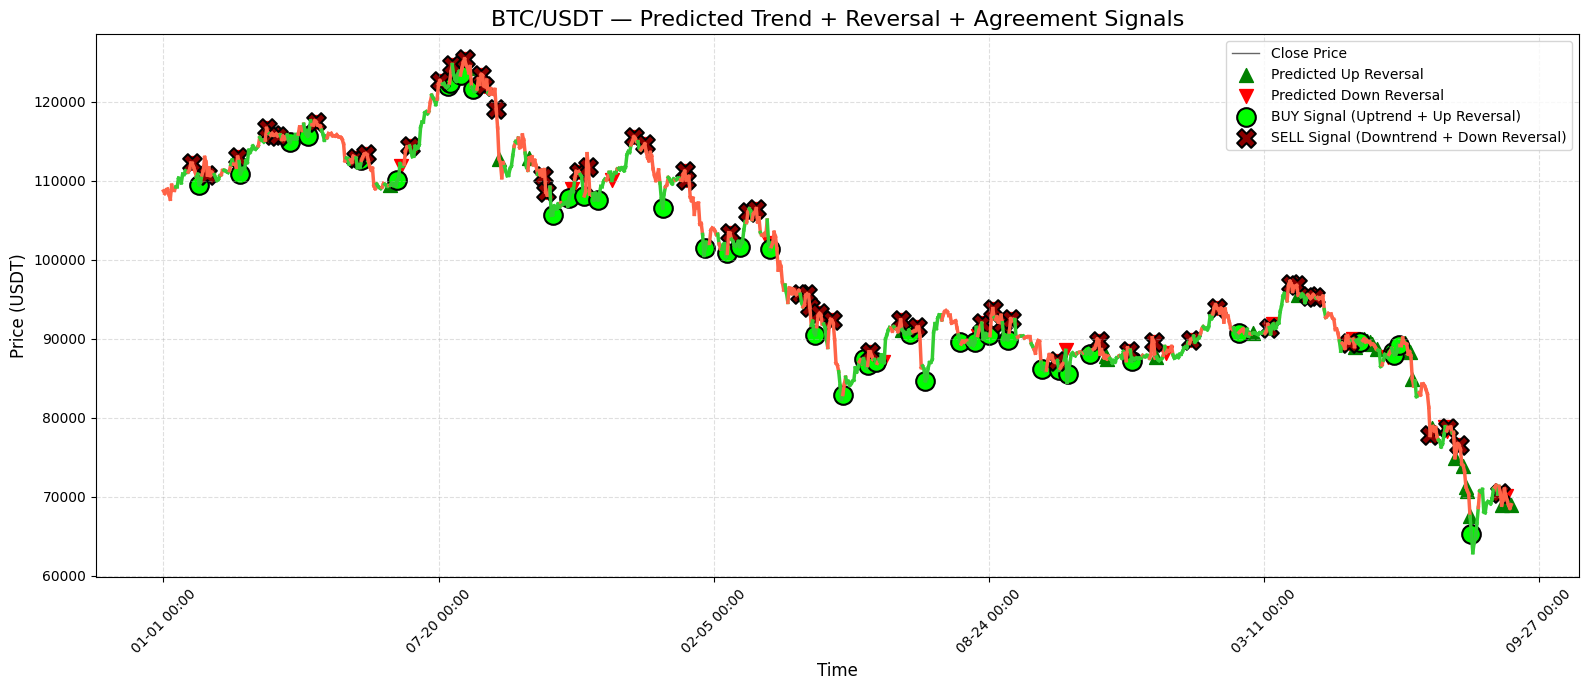

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_final_predictions(df_features, df_trend_pred, df_reversal_pred, symbol='BTC/USDT'):
    """
    Plot price with predicted trend lines and predicted reversal points,
    highlighting where both models agree (buy/sell signals).
    """

    plt.figure(figsize=(16,7))
    x = df_features.index
    y = df_features['close']

    # --- Price line ---
    plt.plot(x, y, color='black', linewidth=1, alpha=0.6, label='Close Price')

    # --- Trend predictions ---
    df_trend_aligned = df_trend_pred.reindex(df_features.index)
    for i in range(1, len(df_trend_aligned)):
        color = 'limegreen' if df_trend_aligned['Predicted'].iloc[i] == 1 else 'tomato'
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=color, linewidth=2.5)

    # --- Reversal predictions ---
    df_reversal_aligned = df_reversal_pred.reindex(df_features.index)
    uprev_idx = df_reversal_aligned.index[df_reversal_aligned['Predicted'] == 2]
    downrev_idx = df_reversal_aligned.index[df_reversal_aligned['Predicted'] == 0]

    plt.scatter(uprev_idx, df_features.loc[uprev_idx, 'close'], marker='^', color='green', s=100, label='Predicted Up Reversal')
    plt.scatter(downrev_idx, df_features.loc[downrev_idx, 'close'], marker='v', color='red', s=100, label='Predicted Down Reversal')

    # --- Agreement Zones ---
    agree_up = df_features.index[
        (df_trend_aligned['Predicted'] == 1) & (df_reversal_aligned['Predicted'] == 2)
    ]
    agree_down = df_features.index[
        (df_trend_aligned['Predicted'] == 0) & (df_reversal_aligned['Predicted'] == 0)
    ]

    # --- Buy/Sell markers ---
    plt.scatter(agree_up, df_features.loc[agree_up, 'close'],
                marker='o', color='lime', s=180, edgecolor='black', linewidth=1.5,
                label='BUY Signal (Uptrend + Up Reversal)')
    plt.scatter(agree_down, df_features.loc[agree_down, 'close'],
                marker='X', color='darkred', s=180, edgecolor='black', linewidth=1.5,
                label='SELL Signal (Downtrend + Down Reversal)')

    # --- Formatting ---
    plt.title(f"{symbol} — Predicted Trend + Reversal + Agreement Signals", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price (USDT)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Usage example
plot_final_predictions(df_features, df_trend, df_reversal)
